In [1]:
import torch
print torch.__version__
import numpy as np

0.1.12


In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Read data

In [4]:
tmp = pd.read_csv('../../../data/input_formated/final/x_item_train.csv').iloc[:,1:]

In [5]:
x_train = np.array(tmp[[u'movie_id', u'category_Action', u'category_Adventure',
       u'category_Animation', u'category_Children\'s', u'category_Comedy',
       u'category_Crime', u'category_Documentary', u'category_Drama',
       u'category_Fantasy', u'category_Film-Noir', u'category_Horror',
       u'category_Musical', u'category_Mystery', u'category_Romance',
       u'category_Sci-Fi', u'category_Thriller', u'category_War',
       u'category_Western']].drop_duplicates(), dtype = np.float32)[:, 1:]
print x_train.shape

(2371, 18)


In [6]:
tmp = pd.read_csv('../../../data/input_formated/final/y_train.csv').iloc[:,1:]

In [7]:
y_train = np.array(tmp[['movie_id', 'mean_rate']].drop_duplicates(), dtype = np.float32)[:, 1:].reshape((-1, 1))
print y_train.shape

(2371, 1)


In [8]:
tmp = pd.read_csv('../../../data/input_formated/final/x_item_val.csv').iloc[:,1:]
x_val = np.array(tmp[[u'movie_id', u'category_Action', u'category_Adventure',
       u'category_Animation', u'category_Children\'s', u'category_Comedy',
       u'category_Crime', u'category_Documentary', u'category_Drama',
       u'category_Fantasy', u'category_Film-Noir', u'category_Horror',
       u'category_Musical', u'category_Mystery', u'category_Romance',
       u'category_Sci-Fi', u'category_Thriller', u'category_War',
       u'category_Western']].drop_duplicates(), dtype = np.float32)[:, 1:]
print x_val.shape

(593, 18)


In [9]:
tmp = pd.read_csv('../../../data/input_formated/final/y_val.csv').iloc[:,1:]

In [10]:
y_val = np.array(tmp[['movie_id', 'mean_rate']].drop_duplicates(), dtype = np.float32)[:, 1:].reshape((-1, 1))
print y_val.shape

(593, 1)


### Model

In [11]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

### Train

### ANN

In [12]:
# Neural Network Model (1 hidden layer)
class ANN_1hidden(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN_1hidden, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.activate = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(output_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activate(out)
        out = self.fc2(out)
        out = self.bn(out)
        return out

In [13]:
def train(x_train, y_train, x_val, y_val, learning_rate, num_epochs, check_point, model_save = None):
	model = ANN_1hidden(x_train.shape[1], 10, y_train.shape[1])
	criterion = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	train_loss_list, val_loss_list = [], []

	#early stopping
	max_patience = 100
	patience = max_patience
	best_val = None
	
	# Train the Model 
	for epoch in range(num_epochs):
		# Convert numpy array to torch Variable
		inputs = Variable(torch.from_numpy(x_train))
		targets = Variable(torch.from_numpy(y_train), requires_grad = False)

		# Forward + Backward + Optimize
		optimizer.zero_grad()  
		outputs = model(inputs)
		
		train_loss = criterion(outputs, targets).sum()
		train_loss_list.append(train_loss.data[0])
		
		#validate
		inputs = Variable(torch.from_numpy(x_val))
		targets = Variable(torch.from_numpy(y_val), requires_grad = False)
		outputs = model(inputs)   
		val_loss = criterion(outputs, targets).sum().data[0]
		val_loss_list.append(val_loss)
		
		#optimize
		train_loss.backward()
		optimizer.step()
		
		if (epoch == 0) or ((epoch+1) % check_point == 0) or (epoch == num_epochs-1):
			print ('Epoch [%d/%d], Training Loss: %.4f, Validating Loss: %.4f' 
				   %(epoch+1, num_epochs, train_loss.data[0], val_loss))
			if model_save is not None:            
				torch.save(model, '%s/%d.pth' % (model_save, epoch+1))

		if (best_val is None) or ((best_val is not None) and (val_loss < best_val)) :
			best_val = val_loss
			patience =max_patience
		else:
			patience -= 1
		if patience == 0:
			print 'Early stopping at %d' % epoch
			break
		

	# Plot the graph
	print 'Plot graph from epoch 10th'
	plt.plot(range(len(train_loss_list))[10:], train_loss_list[10:], label='train')
	plt.plot(range(len(train_loss_list))[10:], val_loss_list[10:], label = 'validate')
	plt.legend()
	plt.show()
	return model

Epoch [1/10000], Training Loss: 0.4369, Validating Loss: 0.4341
Epoch [100/10000], Training Loss: 0.0152, Validating Loss: 0.0166
Epoch [200/10000], Training Loss: 0.0145, Validating Loss: 0.0172
Early stopping at 230
Plot graph from epoch 10th


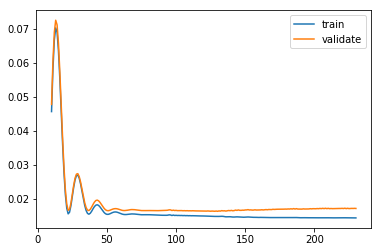

In [14]:
model = train(x_train, y_train, x_val, y_val, learning_rate = 0.1, num_epochs= 10000, check_point = 100)

# Test

In [15]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [16]:
model

ANN_1hidden (
  (fc1): Linear (18 -> 10)
  (activate): Sigmoid ()
  (fc2): Linear (10 -> 1)
  (bn): BatchNorm1d(1, eps=1, momentum=0.1, affine=True)
)

In [17]:
predict = model(Variable(torch.from_numpy(x_train))) * 5
targets = Variable(torch.from_numpy(np.array(y_train * 5, dtype=np.float32)))
rmse(predict, targets).sum()

Variable containing:
 0.6008
[torch.FloatTensor of size 1]

In [18]:
predict = model(Variable(torch.from_numpy(x_val))) * 5
targets = Variable(torch.from_numpy(np.array(y_val * 5, dtype=np.float32)))
rmse(predict, targets).sum()

Variable containing:
 0.6563
[torch.FloatTensor of size 1]

In [19]:
torch.save(model, 'baseline.pth')

/home/anla/Apps/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ANN_1hidden. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
